In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import choice, normal

from scipy.signal import periodogram, correlate, convolve
from scipy.optimize import curve_fit

from glob import glob

from datetime import datetime

from local_utils import *

aspect_ratio = 16./9 # On HD projectors nowadays, this is the aspect ratio.
                     # so I make my figures using that ratio so they show up nicely in presentations.
BoiseState_blue = "#0033A0"
BoiseState_orange = "#D64309"

# Von Karman's constant
kappa = 0.4

In [2]:
# Grab data
heights = {"48": 62, "49": 85, "50": 108, "51": 154}
# heights = {"50": 107, "51": 128}
anemometer_names = heights.keys()
# sampling is 0.5 Hz / once every two seconds for all of them
windspeeds = {}

for key in heights.keys():
    ls = glob("Field_Experiments/Drone_Experiments/Seal Beach*%s*.csv" % key)
    
    data = np.genfromtxt(ls[0], skip_header=10, delimiter=',')

    # Convert from km/hr to cm/s
    windspeeds[key] = data[:,7]*100.
    # The data didn't record seconds for some reason.
    time = np.arange(0, 2.*(len(data[:, 7])), 2)
    
    print(windspeeds[key])

[560. 590. 630. ... 470. 500. 450.]
[590. 610. 600. ... 480. 510. 460.]
[590. 580. 600. ... 510. 530. 500.]
[680. 630. 680. ... 560. 560. 520.]


In [3]:
def calc_sigma_ustar(kappa, sigma_slope):
    return kappa*sigma_slope

def calc_sigma_zstar(slope, zstar, sigma_slope, intercept, sigma_intercept, slope_intercept_corr):
    return zstar/slope*np.sqrt(sigma_intercept**2 + (intercept/slope)**2*sigma_slope**2 +\
                               2*(intercept/slope)*slope_intercept_corr)

def retrieve_relevant_times(time, t0, sample_time):
    return ((time - t0) <= sample_time) & ((time - t0) > 0.)

def sample_wind_profile(sample_time, t0, time=time, windspeeds=windspeeds):
    """
    Return wind speeds from four height sampled over the given sample time
    
    Args:
        sample_time (float): time over which to average in seconds
        t0 (float, optional): time at which at start averages
        time (float array, optional): measured times
        windspeeds (dict of float arrays, optional): wind speed time-series referenced by anemometer name
    
    Returns:
        Wind speeds averaged for sample time from different anemometer times series, one after another
    """
    
    # Run through each height, assuming the first one in windspeeds is the lowest and on up
    cur_t0 = t0
    
    averaged_heights = np.array([])
    averaged_windspeeds = np.array([])
    std_windspeeds = np.array([])
    for key in windspeeds.keys():
        ind = retrieve_relevant_times(time, t0, sample_time) 
        
        averaged_windspeeds = np.append(np.mean(windspeeds[key][ind]), averaged_windspeeds)
        averaged_heights = np.append(heights[key], averaged_heights)
        std_windspeeds = np.append(np.std(windspeeds[key][ind])/(np.sqrt(len(windspeeds[key][ind])) - 1.),
                                   std_windspeeds)
        
        cur_t0 += sample_time
        
    return averaged_heights, averaged_windspeeds, std_windspeeds

def calc_num_points(sample_time, sampling):
    return np.floor(sample_time/sampling)

26.084137762184124 0.013830522872728783
2.9113837513709235 0.013654426085137719
wind errors:  [4.69187957 4.68811677 4.59604079 5.01843588]


Text(0.5, 0, 'Average Wind Speed (${\\rm cm\\ s^{-1}}$)')

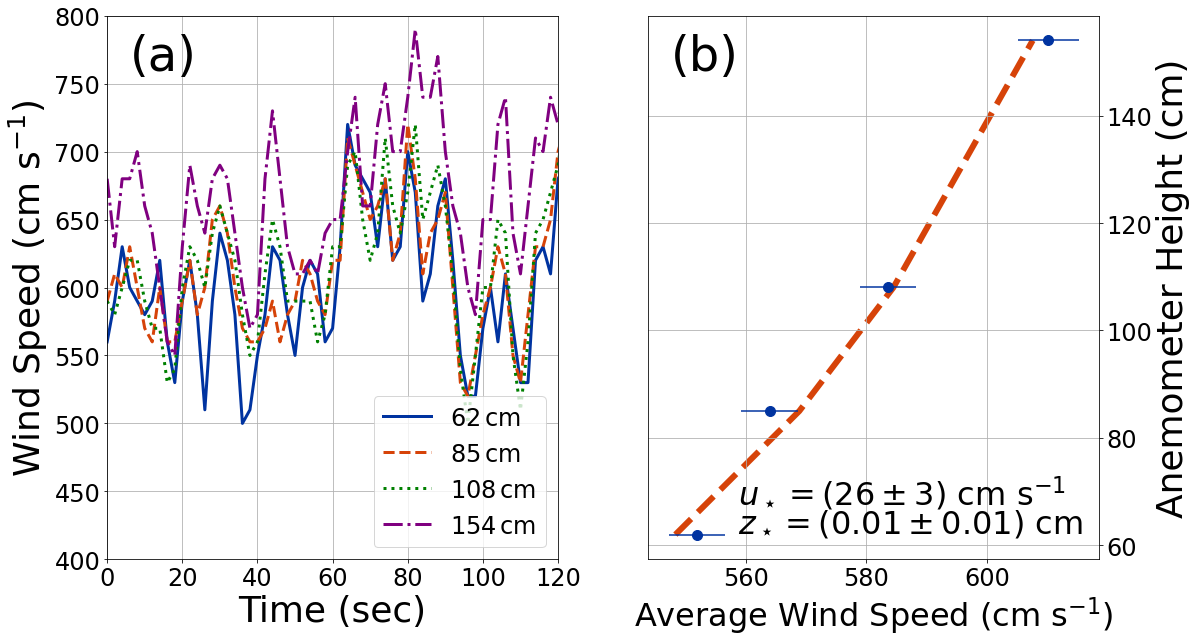

In [56]:
fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax1 = fig.add_subplot(121)

heights = {"48": 62, "49": 85, "50": 108, "51": 154}
# heights = {"50": 107, "51": 128}
anemometer_names = heights.keys()

# Set my own colors
color = iter([BoiseState_blue, BoiseState_orange, 'green', 'purple'])
linestyles = iter(['-', '--', ':', '-.'])

# sampling is 0.5 Hz / once every two seconds for all of them
windspeeds = {}
means = {}
stds = {}

sample_time = 60.
t0 = 0.

for key in heights.keys():
# for key in ["48"]:
    c = next(color)
    linestyle = next(linestyles)
    
    ls = glob("Field_Experiments/Drone_Experiments/Seal Beach*%s*.csv" % key)
    
    data = np.genfromtxt(ls[0], skip_header=10, delimiter=',')

    # Convert from m/s to cm/s
    windspeeds[key] = data[:,7]*100.
    
    means[key] = np.mean(data[:, 7]*100.)
    
    # error on the mean
    stds[key] = np.std(data[:, 7]*100.)/np.sqrt(len(data[:, 7]))
    
    # The data didn't record seconds for some reason.
    time = np.arange(0, 2.*(len(data[:, 7])), 2)
    ax1.plot(time, data[:, 7]*100., lw=3, color=c, ls=linestyle, label=r'$%s\,{\rm cm}$' % heights[key])

    # Add mean illustration
#     ind = retrieve_relevant_times(time, t0, sample_time)
#     mean_windspeed = np.mean(windspeeds[key][ind])
#     ax1.axhline(mean_windspeed, lw=6, alpha=0.5, color=c, ls=linestyle)
    
    t0 += sample_time
    
ax1.set_xlim([0, 120])
ax1.set_ylim([400, 800])
ax1.grid(True)
ax1.tick_params(labelsize=24)
ax1.set_xlabel("Time (sec)", fontsize=36)
ax1.set_ylabel(r'Wind Speed (${\rm cm\ s^{-1}}$)', fontsize=36)
ax1.text(0.05, 0.90, "(a)", fontsize=48, transform=ax1.transAxes)
ax1.legend(loc='lower right', fontsize=24)

#### Estimating Roughness Scale ####

ax2 = fig.add_subplot(122)

x = np.array(list(heights.values()))
y = np.array(list(means.values()))

# Law-of-the-Wall fit
log_z = np.log(x/np.min(x))
popt, pcov = curve_fit(lin_fit, log_z, y, sigma=xerr)
unc = np.sqrt(np.diag(pcov))

# Re-scale sigma
xerr = rescale_sigma(y, lin_fit(log_z, *popt), np.array(list(stds.values())))

ustar = calc_ustar_from_slope(kappa, popt[0])
sigma_ustar = calc_sigma_ustar(kappa, unc[0])
zstar = calc_zstar_from_slope_and_intercept(np.min(x), popt[0], popt[1])
sigma_zstar = calc_sigma_zstar(popt[0], zstar, unc[0], popt[1], unc[1], np.abs(pcov[0,1]))

saved_zstar = zstar
saved_sigma_zstar = sigma_zstar

saved_ustar = ustar
saved_sigma_ustar = sigma_ustar

print(ustar, zstar)
print(sigma_ustar, sigma_zstar)
print("wind errors: ", xerr)

ax2.errorbar(y, x, xerr=xerr, ls='', marker='o', markersize=10, color=BoiseState_blue)
ax2.plot(np.polyval(popt, log_z), x, lw=6, color=BoiseState_orange, ls='--', zorder=-1)
ax2.text(0.05, 0.90, "(b)", fontsize=48, transform=ax2.transAxes)
ax2.text(0.2, 0.1, r'$u_\star = \left( %.0f\pm%.0f \right)\ {\rm cm\ s^{-1}}$' % (ustar, sigma_ustar), 
         fontsize=32, transform=ax2.transAxes)
ax2.text(0.2, 0.05, r'$z_\star = \left( %.2f\pm%.2f \right)\ {\rm cm}$' % (zstar, sigma_zstar), 
         fontsize=32, transform=ax2.transAxes)

ax2.grid(True)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.tick_params(labelsize=24)
ax2.set_ylabel("Anemometer Height (cm)", fontsize=36)
ax2.set_xlabel(r'Average Wind Speed (${\rm cm\ s^{-1}}$)', fontsize=32)

# plt.savefig("Alamosa_Parking_Lot_Windspeeds.jpg", dpi=300, bbox_inches="tight")
# plt.savefig("Seal_Beach_Windspeeds.jpg", dpi=300, bbox_inches="tight")

In [11]:
x = np.array(list(heights.values()))
y = np.array(list(means.values()))
yerr = np.array(list(stds.values()))

wind_profile_popt, wind_profile_pcov = curve_fit(wind_profile, x, y, sigma=yerr, p0=[50., 0.1])
wind_profile_unc = np.sqrt(np.diag(wind_profile_pcov))
print(wind_profile_unc)

# Can I correctly propagate uncertainties?
sigma_ustar = calc_sigma_ustar(0.4, unc[0])
sigma_zstar = calc_sigma_zstar(popt[0], zstar, unc[0], popt[1], unc[1], pcov[0,1])
print(sigma_ustar, sigma_zstar)

[2.91138354 0.01365441]
2.9113840745472235 0.01232390676380952


/Users/brian/Documents/research/Optimizing-Number-and-Placement-of-Anemometers/figures and data/local_utils.py:23: RuntimeWarning: invalid value encountered in log
  return ustar/kappa*np.log(z/zstar)


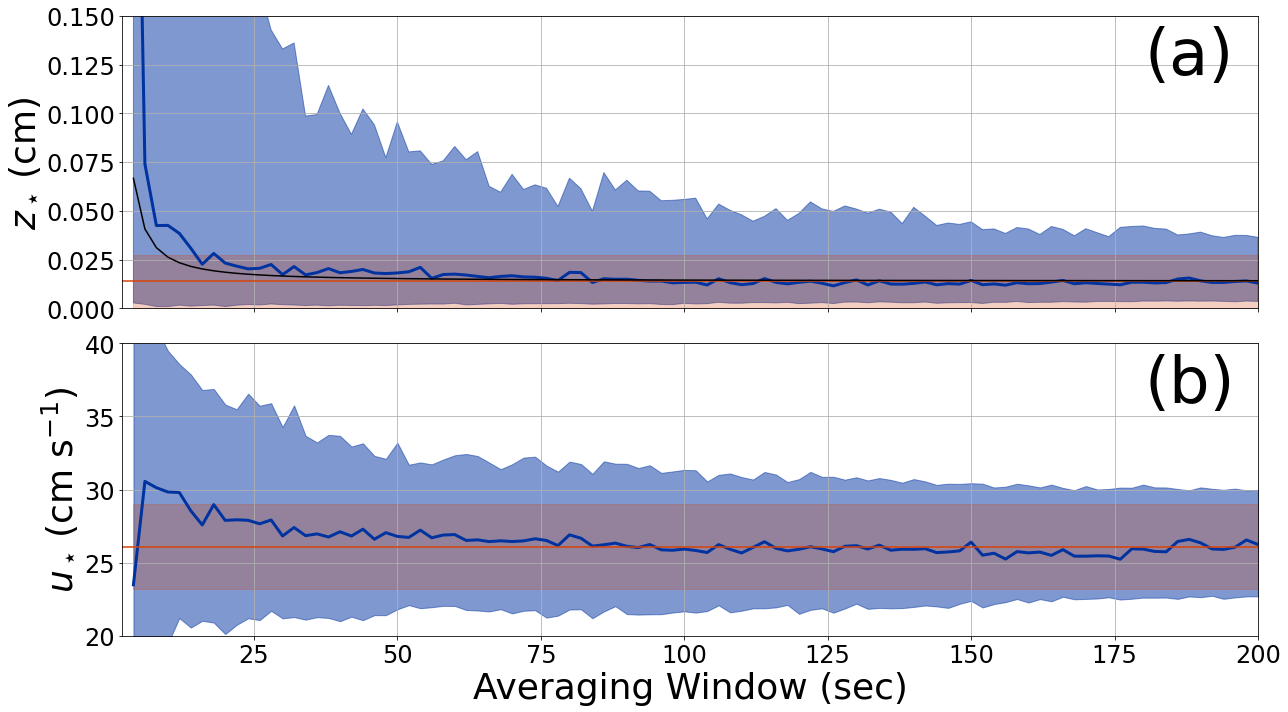

In [40]:
fig = plt.figure(figsize=(10*16/9, 10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1)
# sample_times = 2.**(np.linspace(1, 8, 8))
sample_times = np.arange(4, 202, 2)
# sample_times = np.array([1000])
# print(sample_times)
num_tries = 1000

median_quantile = 0.5
upper_quantile = 0.84
lower_quantile = 0.16

# saved_sample_times = np.array([])

# zstars = np.array([])
# lower_zstar_sigmas = np.array([])
# upper_zstar_sigmas = np.array([])

# ustars = np.array([])
# lower_ustar_sigmas = np.array([])
# upper_ustar_sigmas = np.array([])

# for i in range(len(sample_times)):
#     cur_saved_sample_times = np.array([])
#     cur_zstars = np.array([])
#     cur_ustars = np.array([])
    
#     for j in range(num_tries):
        
#         # Make sure there is plenty of time at the end
#         t0 = choice(time[time < time[-1] - len(heights)*sample_times[i]])
#         averaged_heights, averaged_windspeeds, std_windspeeds = sample_wind_profile(sample_times[i], t0)
    
#         # How about we toss any profile that doesn't increase with altitude?
#         # https://stackoverflow.com/questions/3755136/pythonic-way-to-check-if-a-list-is-sorted-or-not
#         if(all(averaged_windspeeds[i+1] <= averaged_windspeeds[i] for i in range(len(averaged_windspeeds) - 1))):
    
#             x = np.log(averaged_heights/np.min(averaged_heights))
#             y = averaged_windspeeds
#             popt, pcov = curve_fit(lin_fit, x, y, sigma=std_windspeeds)
#             unc = np.sqrt(np.diag(pcov))

#             # If the slope is negative, then we want zstar to be negative.    
#             zstar = calc_zstar_from_slope_and_intercept(np.min(averaged_heights), *popt)
#             cur_zstars = np.append(zstar, cur_zstars)

#             ustar = calc_ustar_from_slope(kappa, popt[0])
#             cur_ustars = np.append(ustar, cur_ustars)
            
#             cur_saved_sample_times = np.append(sample_times[i], cur_saved_sample_times)
            
#     zstars = np.append(np.quantile(cur_zstars, [median_quantile]), zstars)
#     lower_sigma, upper_sigma = np.quantile(cur_zstars, [lower_quantile, upper_quantile]) -\
#         np.quantile(cur_zstars, [median_quantile])
#     lower_zstar_sigmas = np.append(-lower_sigma, lower_zstar_sigmas)
#     upper_zstar_sigmas = np.append(upper_sigma, upper_zstar_sigmas)

#     ustars = np.append(np.quantile(cur_ustars, [median_quantile]), ustars)
#     lower_sigma, upper_sigma = np.quantile(cur_ustars, [lower_quantile, upper_quantile]) -\
#         np.quantile(cur_ustars, [median_quantile])
#     lower_ustar_sigmas = np.append(-lower_sigma, lower_ustar_sigmas)
#     upper_ustar_sigmas = np.append(upper_sigma, upper_ustar_sigmas)
    
#     saved_sample_times = np.append(sample_times[i], saved_sample_times)

ax1.plot(saved_sample_times, zstars, color=BoiseState_blue, lw=3)
ax1.fill_between(saved_sample_times, zstars - lower_zstar_sigmas, 
                zstars + upper_zstar_sigmas, color=BoiseState_blue, alpha=0.5)

# print(saved_sample_times)
# print(zstars)
ax1.axhline(saved_zstar, color=BoiseState_orange)
ax1.fill_between(saved_sample_times, saved_zstar + saved_sigma_zstar, saved_zstar - saved_sigma_zstar, 
                color=BoiseState_orange, alpha=0.25)

ax1.set_ylabel(r'$z_\star\, \left({\rm cm}\right)$', fontsize=36)
ax1.set_ylim([0, 0.15])
ax1.set_xlim([2, 200])
ax1.grid(True)
ax1.tick_params(labelsize=24)
ax1.text(0.9, 0.8, "(a)", fontsize=64, transform=ax1.transAxes)

ax2.plot(saved_sample_times, ustars, color=BoiseState_blue, lw=3)
ax2.fill_between(saved_sample_times, ustars - lower_ustar_sigmas, 
                ustars + upper_ustar_sigmas, color=BoiseState_blue, alpha=0.5)

ax2.axhline(saved_ustar, color=BoiseState_orange)
ax2.fill_between(saved_sample_times, saved_ustar + saved_sigma_ustar, saved_ustar - saved_sigma_ustar, 
                color=BoiseState_orange, alpha=0.25)

ax2.set_xlabel("Averaging Window (sec)", fontsize=36)
ax2.set_ylabel(r'$u_\star\, \left({\rm cm\ s^{-1}}\right)$', fontsize=36)
ax2.set_ylim([20, 40])
ax2.tick_params(labelsize=24)
ax2.grid(True)
ax2.text(0.9, 0.8, "(b)", fontsize=64, transform=ax2.transAxes)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.tight_layout()

### Add analytic estimates ###
sampling = time[1] - time[0]
num_points = calc_num_points(sample_times, sampling)
sigma_over_ustar = np.mean(std_windspeeds)/saved_ustar

analytic_fractional_zstar_sigma = calc_analytic_fractional_zstar_uncertainty(num_points, 
    z0_over_zstar=np.min(averaged_heights)/saved_zstar, 
    sigma_over_ustar=sigma_over_ustar, delta_x=np.log(averaged_heights[-2]/averaged_heights[-1]))
y = (analytic_fractional_zstar_sigma*saved_zstar + saved_zstar)
ax1.plot(sample_times, y, color='k')

# fig.savefig("synthetic_terrestrial_wind_profile.jpg", dpi=300, bbox_inches="tight")